## Libraries

In [35]:
import numpy as np
import pandas as pd

#Data preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

#Building the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#Training the Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Evaluate the Model
from sklearn.metrics import mean_squared_error
from math import sqrt

# Data preprocessing

In [141]:
df = pd.read_csv("data/cleaned_data_first_model.csv")
df = df.reindex(columns=['year', 'country', 'iso_code', 'population', 'GDP', 'primary_energy_consumption', 'cement_co2', 
                         'coal_co2', 'consumption_co2', 'flaring_co2', 'gas_co2', 'land_use_change_co2', 'oil_co2', 
                         'other_industry_co2', 'trade_co2', 'co2_including_luc'])

df.rename(columns={'GDP': 'gdp'}, inplace=True)
df

,year,country,iso_code,population,gdp,primary_energy_consumption,cement_co2,coal_co2,consumption_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2,trade_co2,co2_including_luc
0,1990,China,CHN,1.153704e+09,1.027379e+12,7938.249,84.513,1976.684,2320.346,0.000,29.301,1368.074,330.291,64.065,-164.509,3852.928
1,1991,China,CHN,1.170626e+09,1.122543e+12,8337.610,101.305,2049.920,2399.879,0.000,30.778,1013.113,356.027,68.066,-206.217,3619.209
2,1992,China,CHN,1.183813e+09,1.282220e+12,8773.708,122.445,2114.715,2575.993,0.000,30.239,1054.941,385.793,77.596,-154.794,3785.728
3,1993,China,CHN,1.195856e+09,1.460240e+12,9457.634,142.774,2228.745,2757.112,0.000,35.728,1087.234,428.549,85.855,-164.539,4008.885
4,1994,China,CHN,1.207287e+09,1.650608e+12,10048.812,164.377,2380.586,2750.089,3.737,41.568,1199.356,423.712,89.760,-353.650,4303.095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,2017,United States,USA,3.297912e+08,1.892457e+13,25819.029,40.324,1308.716,5631.146,59.486,1460.656,145.118,2315.177,27.804,418.983,5357.280
316,2018,United States,USA,3.321400e+08,1.948197e+13,26764.953,38.971,1256.631,5798.152,72.066,1619.275,108.298,2366.168,24.686,420.355,5486.095
317,2019,United States,USA,3.343197e+08,1.992898e+13,26574.742,40.896,1071.666,5685.684,88.437,1675.471,112.161,2360.999,24.677,423.539,5374.306
318,2020,United States,USA,3.359420e+08,1.937738e+13,24603.098,40.688,877.920,5186.558,67.749,1656.255,114.729,2047.544,24.472,471.929,4829.357


In [142]:
df['country'].unique()

array(['China', 'Germany', 'India', 'Indonesia', 'Iran', 'Japan',
       'Russia', 'Saudi Arabia', 'Ukraine', 'United States'], dtype=object)

In [143]:

# Filter relevant columns, without 'iso_code'
features = ['year', 'country', 'population', 'gdp', 'primary_energy_consumption', 'cement_co2', 'coal_co2', 'consumption_co2', 
            'flaring_co2', 'gas_co2', 'land_use_change_co2', 'oil_co2', 'other_industry_co2', 'trade_co2', 'co2_including_luc']
df = df[features]

# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

# Normalize the numerical features
numerical_features = ['population', 'gdp', 'primary_energy_consumption', 'cement_co2', 'coal_co2', 'oil_co2', 'gas_co2', 
                      'consumption_co2', 'flaring_co2', 'land_use_change_co2', 'other_industry_co2', 'trade_co2', 'co2_including_luc']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

# Combine the encoded country with the scaled numerical features
df_processed = pd.concat([df[['country', 'year']], df_scaled], axis=1)
df_processed['country_region'] = df_processed['country']
df_processed = df_processed.set_index(['country', 'year'])
df_processed

population       gdp  primary_energy_consumption  \
country       year                                                     
China         1990    0.806943  0.046983                    0.169577   
              1991    0.818945  0.051633                    0.178806   
              1992    0.828298  0.059436                    0.188883   
              1993    0.836840  0.068136                    0.204688   
              1994    0.844947  0.077438                    0.218350   
...                        ...       ...                         ...   
United States 2017    0.222561  0.921573                    0.582786   
              2018    0.224227  0.948812                    0.604646   
              2019    0.225773  0.970656                    0.600250   
              2020    0.226924  0.943701                    0.554687   
              2021    0.227672  1.000000                    0.585698   

                    cement_co2  coal_co2   oil_co2   gas_co2  consumption_co2  \
country       year                                                              
China         1990    0.096198  0.247722  0.114770  0.004959         0.213660   
              1991    0.115813  0.256900  0.124622  0.005852         0.221478   
              1992    0.140507  0.265021  0.136017  0.005526         0.238789   
              1993    0.164254  0.279311  0.152385  0.008844         0.256593   
              1994    0.189489  0.298340  0.150533  0.012374         0.255902   
...                        ...       ...       ...       ...              ...   
United States 2017    0.044579  0.164011  0.874621  0.870153         0.539097   
              2018    0.042999  0.157484  0.894141  0.966032         0.555513   
              2019    0.045247  0.134303  0.892163  1.000000         0.544458   
              2020    0.045004  0.110023  0.772166  0.988385         0.495396   
              2021    0.045733  0.125890  0.845465  0.990180         0.533301   

                    flaring_co2  land_use_change_co2  other_industry_co2  \
country       year                                                         
China         1990     0.000000             0.566681            0.361424   
              1991     0.000000             0.427707            0.383996   
              1992     0.000000             0.444084            0.437760   
              1993     0.000000             0.456727            0.484353   
              1994     0.042256             0.500625            0.506383   
...                         ...                  ...                 ...   
United States 2017     0.672637             0.087872            0.156857   
              2018     0.814885             0.073456            0.139267   
              2019     1.000000             0.074968            0.139216   
              2020     0.766071             0.075974            0.138059   
              2021     0.715696             0.081011            0.140119   

                    trade_co2  co2_including_luc country_region  
country       year                                               
China         1990   0.625347           0.302721          China  
              1991   0.606281           0.283291          China  
              1992   0.629789           0.297134          China  
              1993   0.625334           0.315686          China  
              1994   0.538882           0.340144          China  
...                       ...                ...            ...  
United States 2017   0.892090           0.427781  United States  
              2018   0.892717           0.438489  United States  
              2019   0.894172           0.429196  United States  
              2020   0.916294           0.383893  United States  
              2021   0.947394           0.411364  United States  

[320 rows x 14 columns]

In [144]:
def train_test_split_by_country_year(data, split_ratio=0.8):
    x_train, x_test, y_train, y_test = [], [], [], []

    # Iterate over each unique country in the index
    for country in data.index.get_level_values('country').unique():
        country_data = data.loc[country].copy()
        country_data['country'] = country_data['country_region']
        country_data = country_data.reset_index()
        country_data.set_index(['country_region', 'year'], inplace=True)
        # Calculate the split index
        size = int(len(country_data) * split_ratio)

        # Append the training and test sets for each country
        x_train.append(country_data.drop(columns=['co2_including_luc']).iloc[:size])
        x_test.append(country_data.drop(columns=['co2_including_luc']).iloc[size:])
        y_train.append(country_data['co2_including_luc'].iloc[:size])
        y_test.append(country_data['co2_including_luc'].iloc[size:])

    # Concatenate lists into single DataFrames
    x_train = pd.concat(x_train)
    x_test = pd.concat(x_test)
    y_train = pd.concat(y_train)
    y_test = pd.concat(y_test)

    return x_train, x_test, y_train, y_test

# Assume df is your DataFrame with multi-index ('country_region', 'year')
X_train, X_test, Y_train, Y_test = train_test_split_by_country_year(df_processed, split_ratio=0.8)
X_test['country']


country_region  year
China           2015            China
                2016            China
                2017            China
                2018            China
                2019            China
                            ...      
United States   2017    United States
                2018    United States
                2019    United States
                2020    United States
                2021    United States
Name: country, Length: 70, dtype: object

In [145]:
# Example data preprocessing
encoder = LabelEncoder()

# Assuming train_data and test_data are defined as DataFrames somewhere in your code
# Make sure that the 'country' column is part of your DataFrame
X_train['country'] = encoder.fit_transform(X_train['country']).astype(float)
X_test['country'] = (encoder.transform(X_test['country'])).astype(float)  # Use the same encoder to ensure consistency

In [146]:
train_data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test], axis=1)
test_data.dtypes

population                    float64
gdp                           float64
primary_energy_consumption    float64
cement_co2                    float64
coal_co2                      float64
oil_co2                       float64
gas_co2                       float64
consumption_co2               float64
flaring_co2                   float64
land_use_change_co2           float64
other_industry_co2            float64
trade_co2                     float64
country                       float64
co2_including_luc             float64
dtype: object

In [147]:
# Function to convert series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Aggregate the data
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Function to reshape data for LSTM training
def reshape_data(train, test):
    # Frame as supervised learning
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # Split into input and outputs
    train_X, train_y = reframed_train.values[:, :-1], reframed_train.values[:, -1]
    test_X, test_y = reframed_test.values[:, :-1], reframed_test.values[:, -1]
    # Reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train, x_test, train_y, test_y

In [148]:
# Using the function to obtain reshaped x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)

In [92]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 14. We will make timesteps = 3 (past days data used for training). 
# Convert the data to sequences
# def create_sequences(data, n_steps):
#     X, y = [], []
#     for i in range(len(data) - n_steps):
#         X.append(data.iloc[i:i+n_steps, :-1].values)
#         y.append(data.iloc[i+n_steps, -1])
#     return np.array(X), np.array(y)

# n_steps = 3  # Number of steps in sequences
# X, y = create_sequences(df_processed, n_steps)

# # Splitting the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.shape

(253, 3, 13)

# Building the LSTM Model

In [149]:
# Model architecture adjusted for cuDNN
model = Sequential([
    LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 50)             15600     
                                                                 
 dropout_18 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 35,851
Trainable params: 35,851
Non-trainable params: 0
_________________________________________________________________


2024-05-04 20:24:13.450699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-04 20:24:13.452305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-04 20:24:13.453330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [150]:
x_train


array([[[0.8069427 , 0.04698282, 0.16957661, ..., 0.38399612,
         0.60628058, 0.        ]],

       [[0.81894505, 0.05163324, 0.1788055 , ..., 0.43775986,
         0.62978851, 0.        ]],

       [[0.82829842, 0.05943623, 0.18888336, ..., 0.48435323,
         0.6253336 , 0.        ]],

       ...,

       [[0.2112733 , 0.80978327, 0.58063805, ..., 0.17326255,
         0.84141297, 9.        ]],

       [[0.21324134, 0.82832539, 0.56496535, ..., 0.17402416,
         0.81870505, 9.        ]],

       [[0.21517329, 0.84364147, 0.58067696, ..., 0.18270082,
         0.841418  , 9.        ]]])

# Training the Model

In [151]:
# Callbacks
#checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=70,
    batch_size=50,
    validation_split=0.2,
    verbose=1,
    #shuffle=False
) #callbacks=[checkpoint, early_stopping])

Epoch 1/70


2024-05-04 20:24:17.415597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-04 20:24:17.416604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-04 20:24:17.417347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - ETA: 0s - loss: 0.0364

2024-05-04 20:24:19.646546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-04 20:24:19.647641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-04 20:24:19.648356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 3s 218ms/step - loss: 0.0364 - val_loss: 0.0748
Epoch 2/70
1/4 [======>.......................] - ETA: 0s - loss: 0.0512

2024-05-04 20:24:19.873501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 20:24:19.939390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 20ms/step - loss: 0.0322 - val_loss: 0.0763
Epoch 3/70
4/4 [==============================] - 0s 28ms/step - loss: 0.0278 - val_loss: 0.0765
Epoch 4/70
4/4 [==============================] - 0s 19ms/step - loss: 0.0239 - val_loss: 0.0685
Epoch 5/70
4/4 [==============================] - 0s 17ms/step - loss: 0.0202 - val_loss: 0.0630
Epoch 6/70
4/4 [==============================] - 0s 18ms/step - loss: 0.0158 - val_loss: 0.0607
Epoch 7/70
4/4 [==============================] - 0s 17ms/step - loss: 0.0120 - val_loss: 0.0543
Epoch 8/70
4/4 [==============================] - 0s 18ms/step - loss: 0.0088 - val_loss: 0.0494
Epoch 9/70
4/4 [==============================] - 0s 18ms/step - loss: 0.0066 - val_loss: 0.0341
Epoch 10/70
4/4 [==============================] - 0s 17ms/step - loss: 0.0053 - val_loss: 0.0251
Epoch 11/70
4/4 [==============================] - 0s 20ms/step - loss: 0.0042 - val_loss: 0.0177
Epoch 12/70
4/4 [======================

# Evaluate the Model

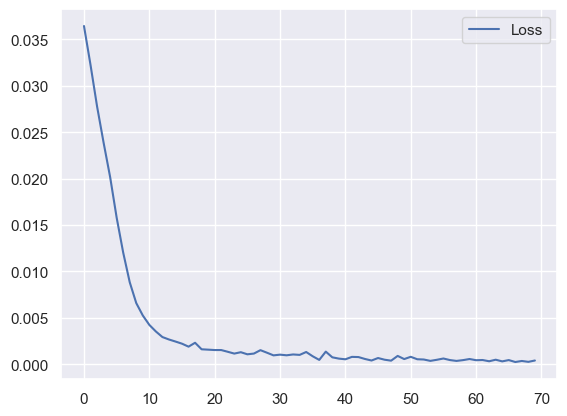

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [24]:
# # Load best model
# model.load_weights('best_model.h5')

# # Predictions
# predictions = model.predict(X_test)

# # Calculate RMSE
# rmse = sqrt(mean_squared_error(y_test, predictions))
# print(f'Test RMSE: {rmse}')

2024-04-14 19:04:47.235100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-14 19:04:47.236151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-14 19:04:47.236789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 7ms/step


2024-04-14 19:04:47.500495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test RMSE: 2935.6501178532512


In [26]:
# from sklearn.metrics import r2_score

# r_squared = r2_score(y_test, predictions)
# print(f"R-squared: {r_squared}")

R-squared: -0.6798754858474061


In [28]:
# y_test

array([ 1108.092,   231.126, 11050.448,   600.134,  4596.373,  1391.162,
        1152.843,  1105.044,   822.253,  1236.327,   438.398,  1196.999,
        1237.176,  1255.47 ,  1782.149,  2212.392,  1140.846,   259.149,
        5357.28 ,   616.672,  1502.014,  1203.942,  1486.282,  1126.777,
         886.139,  1936.231,  5955.642,   927.707,  1233.501,  1218.842,
         284.226,  4430.843,  1267.826,   690.383,  5951.311,  1331.424,
        1222.123,  1631.962,   399.804,  1241.92 ,  4320.913,   561.408,
         226.991,   241.438,   837.065,  4652.544,   474.057,   471.411,
         322.719,  1862.452,   745.749,   303.579,  1197.841,   863.19 ,
        8631.894,  1184.882,  1144.792,   670.441, 10472.555,  1906.015,
        1753.454,  1611.766,   652.308,  1504.48 ])

In [29]:
# predictions

array([28.170801, 28.142565, 28.327816, 28.201881, 28.26894 , 28.120262,
       28.186584, 28.204113, 28.206848, 28.17358 , 28.139961, 28.180769,
       28.14431 , 28.176935, 28.22086 , 28.22923 , 28.20238 , 28.085848,
       28.319931, 28.168257, 28.169788, 28.18947 , 28.159441, 28.164408,
       28.15357 , 28.19388 , 28.293024, 28.11477 , 28.16824 , 28.204058,
       28.21597 , 28.25933 , 28.156338, 28.189888, 28.302681, 28.189884,
       28.184092, 28.144327, 28.108906, 28.1548  , 28.266365, 28.165838,
       28.14703 , 28.139305, 28.16534 , 28.250603, 28.12157 , 28.146935,
       28.264282, 28.218712, 28.192045, 28.096985, 28.150581, 28.162704,
       28.296345, 28.2032  , 28.15025 , 28.201145, 28.326693, 28.25313 ,
       28.216217, 28.15608 , 28.264482, 28.202871], dtype=float32)

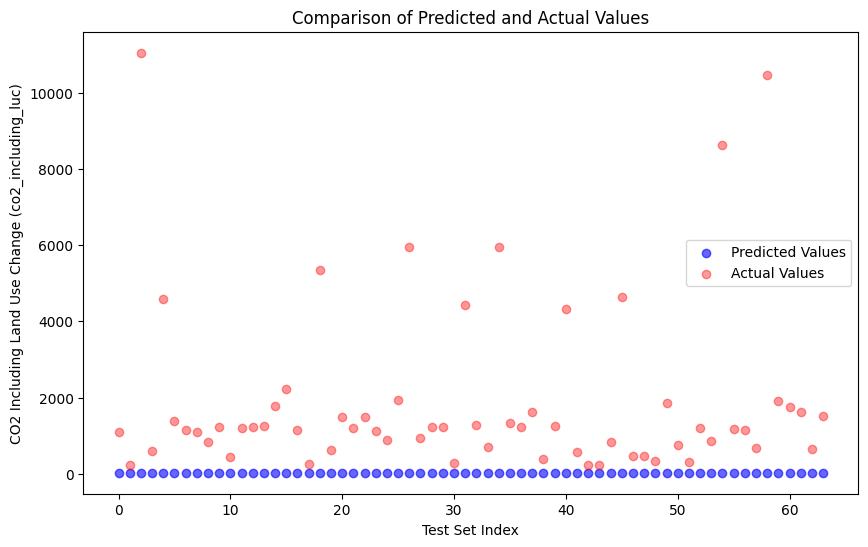

In [25]:
# import matplotlib.pyplot as plt

# # Assuming `predictions` and `y_test` are already defined

# # Convert predictions from 2D array to 1D (if necessary)
# predictions = predictions.flatten()

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.scatter(range(len(predictions)), predictions, color='blue', label='Predicted Values', alpha=0.6)
# plt.scatter(range(len(y_test)), y_test, color='red', label='Actual Values', alpha=0.4)
# plt.title('Comparison of Predicted and Actual Values')
# plt.xlabel('Test Set Index')
# plt.ylabel('CO2 Including Land Use Change (co2_including_luc)')
# plt.legend()
# plt.show()

In [153]:
# make a prediction
y_test_pre=model.predict(x_test)
# check length
y_test_pre.shape,y_test.shape

2024-05-04 20:24:57.364195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-04 20:24:57.365271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-04 20:24:57.366016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/3 [=========>....................] - ETA: 1s

2024-05-04 20:24:57.623658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-04 20:24:57.711705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 20ms/step


((69, 1), (69,))

In [154]:
X_test

population       gdp  primary_energy_consumption  \
country_region year                                                     
China          2015    0.977177  0.537328                    0.798067   
               2016    0.982975  0.574349                    0.801382   
               2017    0.988923  0.614475                    0.833074   
               2018    0.993741  0.656168                    0.873890   
               2019    0.997142  0.695405                    0.915273   
...                         ...       ...                         ...   
United States  2017    0.222561  0.921573                    0.582786   
               2018    0.224227  0.948812                    0.604646   
               2019    0.225773  0.970656                    0.600250   
               2020    0.226924  0.943701                    0.554687   
               2021    0.227672  1.000000                    0.585698   

                     cement_co2  coal_co2   oil_co2   gas_co2  \
country_region year                                             
China          2015    0.840857  0.910713  0.497020  0.216973   
               2016    0.865445  0.886203  0.508134  0.242164   
               2017    0.883131  0.897722  0.535984  0.281231   
               2018    0.916493  0.916907  0.562738  0.335034   
               2019    0.963371  0.942820  0.585421  0.368160   
...                         ...       ...       ...       ...   
United States  2017    0.044579  0.164011  0.874621  0.870153   
               2018    0.042999  0.157484  0.894141  0.966032   
               2019    0.045247  0.134303  0.892163  1.000000   
               2020    0.045004  0.110023  0.772166  0.988385   
               2021    0.045733  0.125890  0.845465  0.990180   

                     consumption_co2  flaring_co2  land_use_change_co2  \
country_region year                                                      
China          2015         0.857276     0.044110             0.178267   
               2016         0.856974     0.034940             0.114576   
               2017         0.884247     0.033572             0.211703   
               2018         0.930734     0.038536             0.303753   
               2019         0.961927     0.043409             0.324690   
...                              ...          ...                  ...   
United States  2017         0.539097     0.672637             0.087872   
               2018         0.555513     0.814885             0.073456   
               2019         0.544458     1.000000             0.074968   
               2020         0.495396     0.766071             0.075974   
               2021         0.533301     0.715696             0.081011   

                     other_industry_co2  trade_co2  country  
country_region year                                          
China          2015            0.932087   0.243932      0.0  
               2016            0.947370   0.289118      0.0  
               2017            0.957553   0.303445      0.0  
               2018            0.967742   0.362941      0.0  
               2019            1.000000   0.340191      0.0  
...                                 ...        ...      ...  
United States  2017            0.156857   0.892090      9.0  
               2018            0.139267   0.892717      9.0  
               2019            0.139216   0.894172      9.0  
               2020            0.138059   0.916294      9.0  
               2021            0.140119   0.947394      9.0  

[70 rows x 13 columns]

In [155]:
pa=pd.DataFrame()
pa['Date']=X_test.reset_index().year.iloc[1:-1]
pa['Country']=X_test.reset_index().country_region.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa = pa[pa['Country'] == 'Germany']
pa

,Date,Country,Prediction,Actual Values
7,2015,Germany,0.056406,0.048171
8,2016,Germany,0.056704,0.048667
9,2017,Germany,0.055406,0.047399
10,2018,Germany,0.054587,0.044414
11,2019,Germany,0.052251,0.040503
12,2020,Germany,0.053067,0.035506
13,2021,Germany,0.168084,0.038154


In [139]:
pa.groupby('Date')['Prediction'].sum()

Date
2015    0.061252
2016    0.061768
2017    0.060716
2018    0.059298
2019    0.057315
2020    0.056234
2021    0.117130
Name: Prediction, dtype: float32

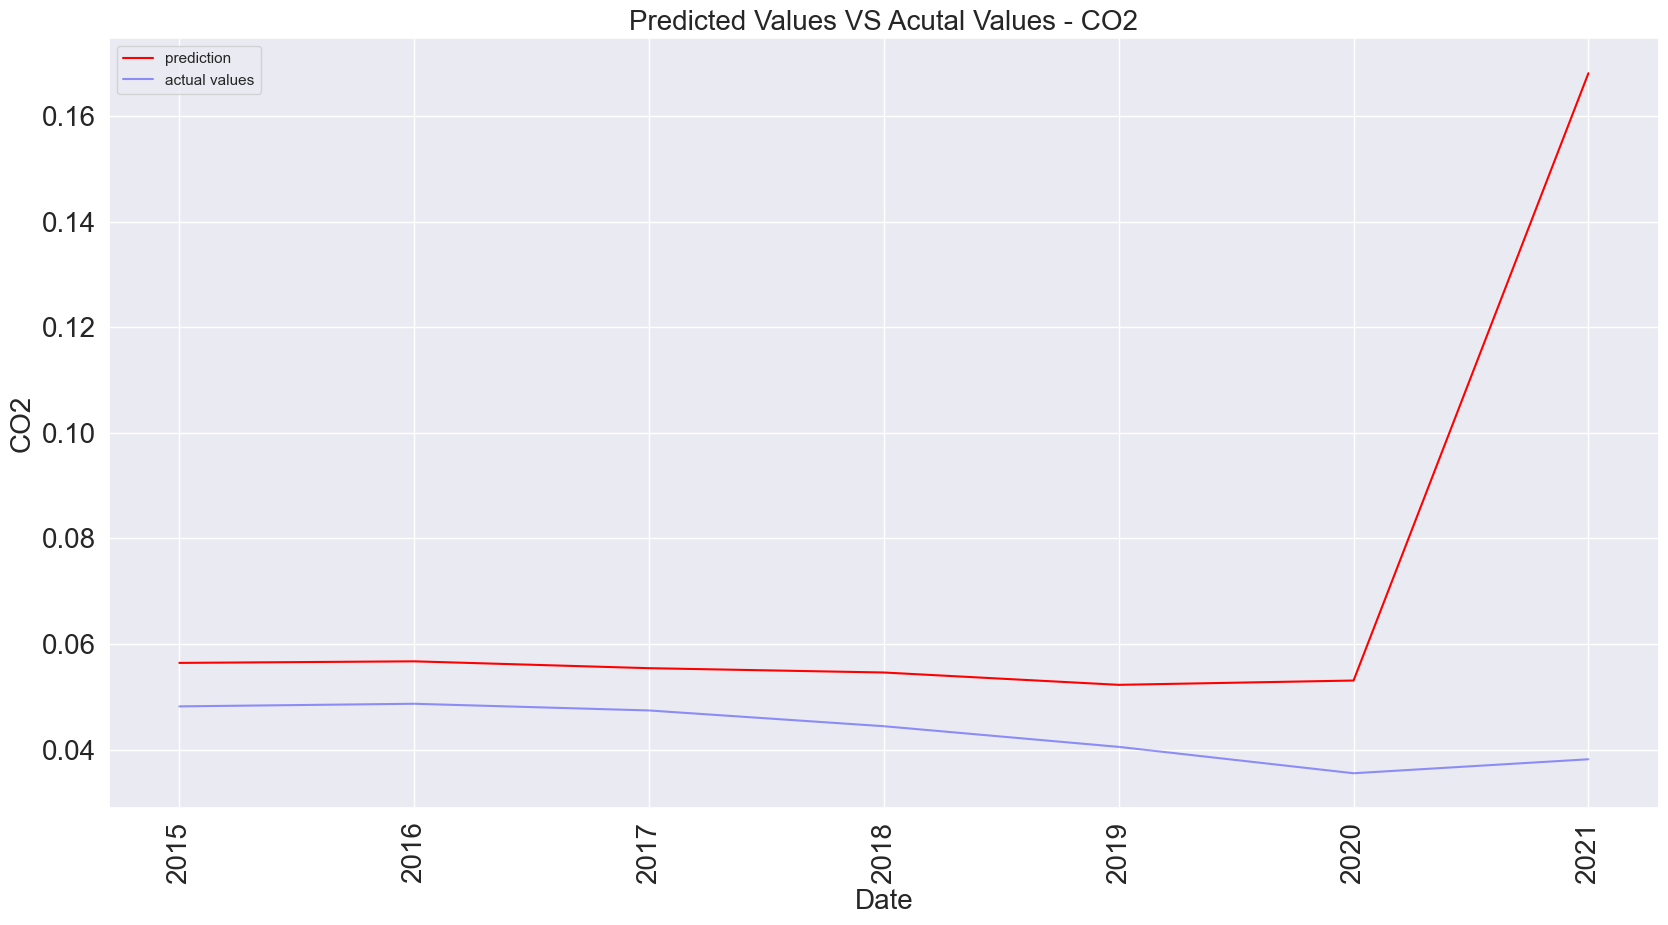

In [156]:
plt.figure(figsize=(20,10))
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('CO2',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - CO2',fontsize=20)
plt.legend()

In [157]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [158]:
print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))

0.13334309933978458
